# OMF.v2 Block Model Storage

**Authors:** Rowan Cockett, Franklin Koch <br>
**Company:** Seequent <br>
**Date:** March 3, 2019

## Overview

The proposal below defines a storage algorithm for all sub block model formats in OMF.v2.
The storage & access algorithm is based on [sparse matrix/array storage](https://en.wikipedia.org/wiki/Sparse_matrix#Storing_a_sparse_matrix) in linear algebra.
The algorithm for the _Compressed Block Storage_ format is largely similar between the various block model formats supported by OMF.v2:

* _Regular Block Model_: No aditional storage information necessary.
* _Tensor Block Model_: No aditional storage information necessary.
* _Regular Sub Block Model_: Single storage array required to record sub-blocking and provide indexing into attribute arrays.
* _OcTree Sub Block Model_: Storage array required as well as storage for each Z-Order Curve per octree (discussed in detail below).
* _Arbitrary Sub Block Model_: Storage array required as well as storage of sub-block centroids and sizes.

## Summary

* The compression format for a _Regular Sub Block Model_ scales with parent block count rather than sub block count.
* Storing an _Octree Sub Block Model_ is 12 times more efficient than an _Arbitrary Sub Block Model_ for the same structure. For example, an _Octree Sub Block Model_ with 10M sub-blocks would save 3.52 GB of space.
* Attributes for all sub-block types are stored on-disk in contiguous chunks per parent block, allowing for easy memory mapping of attributes, if necessary.


In [1]:
import cbs
import cbs_plot
import z_order_utils
import numpy as np
%matplotlib inline

# All Block Models

All block models have been decided to be defined inside of a rotated coordinate frame. The implementation of this orientation uses three `axis` vectors (named `axis_u`, `axis_v` and `axis_w`) and a `corner` that defines a bounding box in the project coordinate reference system. These vectors must be orthogonal but are not opinionated about "handed-ness". The implementation is explicitly not (a) rotation matrices, which may have skew and or (b) defined as three rotations, which may be applied in other orders (e.g. `ZYX` vs `YXZ`) and not be consistent. The unwrapping of attributes and the `ijk` block index is relative to these axis, respectively, in the rotated coordinate frame.

**Stored Properties**

* `name` - Name of the block model
* `description` - Description of the block model
* `attributes` - list of standard [OMF.v1 attributes](https://omf.readthedocs.io/en/stable/content/data.html#scalardata)
* `axis_u` (Vector3) Orientation of the i-axis in the project CRS
* `axis_v` (Vector3) Orientation of the j-axis in the project CRS
* `axis_w` (Vector3) Orientation of the k-axis in the project CRS
* `corner` (Vector3) Minimum u/v/w in the project CRS

**Attributes**

All block models are stored with flat attribute arrays, allowing for efficient storage and access, as well as adhering to existing standards set out for all other Elements in the OMF.v1 format. The standard counting is _column major ordering_, following "Fortran" style indexing -- in `numpy` (Python) this uses `array.flatten(order='F')` where array is the 3D attribute array. To be explicit, inside a for-loop the `i` index always moves the fastest:

```python
count = regular_block_model.block_count
index = 0
for k in range(count[2]):
    for j in range(count[1]):
        for i in range(count[0]):
            print(index, (i, j, k))
            index += 1
```

# Regular Block Model

**Stored Properties**

* `block_size`: a Vector3 (Float64) that describes how large each block is
* `block_count`: a Vector3 (Int16) that describes how many blocks in each dimension

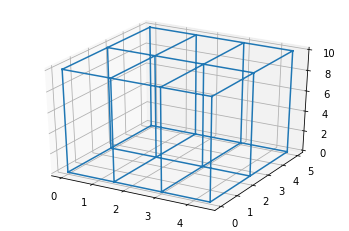

In [2]:
rbm = cbs.RegularBlockModel()
rbm.block_size = [1.5, 2.5, 10.]
rbm.block_count = [3, 2, 1]
rbm.validate()

cbs_plot.plot_rbm(rbm)

# Tensor Block Model

**Stored Properties**

* `tensor_u`: a Float64 array of spacings along `axis_u`
* `tensor_v`: a Float64 array of spacings along `axis_v`
* `tensor_w`: a Float64 array of spacings along `axis_w`

**Note:** `block_size[0]` for the i-th block is `tensor_u[i]` and `block_count[0]` is `len(tensor_u)`. Counting for attributes is the same as _Regular Block Model_.

block_count: [3, 2, 1]
num_blocks: 6


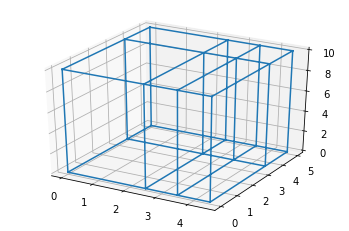

In [3]:
tbm = cbs.TensorBlockModel()
tbm.tensor_u = [2.5, 1.0, 1.0]
tbm.tensor_v = [3.5, 1.5]
tbm.tensor_w = [10.0]
tbm.validate()

print("block_count:", tbm.block_count)
print("num_blocks:", tbm.num_blocks)
cbs_plot.plot_tbm(tbm)

# Regular Sub Block Model

The `RegularSubBlockModel` requires storage of information to store the parent and sub block counts as well as the parent block sizes.

**Stored Properties**

* `parent_block_size`: a Vector3 (Float64) that describes how large each parent block is
* `parent_block_count`: a Vector3 (Int16) that describes how many parent blocks in each dimension
* `sub_block_count`: a Vector3 (Int16) that describes how many sub blocks in each dimension are contained within each parent block
* `compressed_block_storage`: a UInt32 array of length (`i * j * k + 1`) that defines the sub block topology

## Compressed Block Storage

The _Compressed Block Storage_ format (or `cbs` in code) is a monotonically increasing integer array, which starts at 0 (`cbs[0] := 0`) and ends at the total number of attributes `cbs[i * j * k] := num_blocks`. For the n-th parent block, `cbs[n+1] - cbs[n]` will always be 1 or the pre-defined number of sub-blocks per parent (`prod(sub_block_count)` for a _Regular Sub Block Model_). This can be used to determine if the n-th parent block is sub-blocked (i.e. `is_sub_blocked[n]`), as well as the index into any attribute array to retrive all of the attribute data for that parent block. That is, `attribute[cbs[n] : cbs[n+1]]` will always return the attributes for the n-th parent block, regardless of if the parent block is sub-blocked or not. The `cbs` indexing is also useful for the Octree and Arbitrary Sub Block Models, allowing additional topology information about the tree structure or arbitrary sub-blocks, respectively, to be stored in a single array.

The _Compressed Block Storage_ format means the total size for storage is a fixed length `UInt32` array (or 64, depending on the upper limit required for number of blocks) plus a small amount of metadata (i.e. nine extra numbers, name, description, etc.). That is, this compression format **scales with the parent block count** rather than the sub-block count. All other information can be derived from the `cbs` array (e.g. `is_sub_blocked` as a boolean and all indexing into the attribute arrays).

The technique can be used as the base storage for all flowing sub block types.

cbs: [0 1 2 3 4 5 6]
num_blocks: 6
is_sub_blocked: [False False False False False False]
sub_block_size: [0.75 1.25 5.  ]


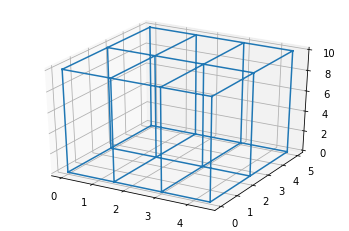

In [4]:
rsbm = cbs.RegularSubBlockModel()
rsbm.parent_block_size = [1.5, 2.5, 10.]
rsbm.parent_block_count = [3, 2, 1]
rsbm.sub_block_count = [2, 2, 2]
rsbm.validate()

print("cbs:", rsbm.compressed_block_storage)
print("num_blocks:", rsbm.num_blocks)
print("is_sub_blocked:", rsbm.is_sub_blocked)
print("sub_block_size:", rsbm.sub_block_size)
cbs_plot.plot_rsbm(rsbm)

cbs: [ 0  1  2  3 11 12 13]
num_blocks: 13
is_sub_blocked: [False False False  True False False]
sub_block_size: [0.75 1.25 5.  ]


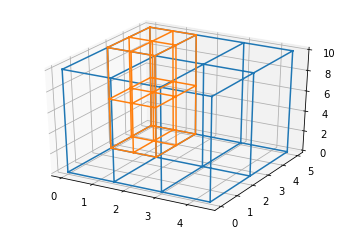

In [5]:
rsbm.refine((0, 1, 0))

print("cbs:", rsbm.compressed_block_storage)
print("num_blocks:", rsbm.num_blocks)
print("is_sub_blocked:", rsbm.is_sub_blocked)
print("sub_block_size:", rsbm.sub_block_size)
cbs_plot.plot_rsbm(rsbm)

# Octree Sub Block Model

The _Octree Sub Block Model_ is a "forest" of individual octrees, with the "root" of every octree positioined at the center of each parent block within a _Regular Block Model_. Each octree is stored as a [Linear Octree](https://en.wikipedia.org/wiki/Linear_octree) with the space-filling curve chosen to be a [Z-Order Curve](https://en.wikipedia.org/wiki/Z-order_curve) (also known as a Morton curve). The Z-Order curve was chosen based on the efficient properties of bit-interleaving to produce a sorted integer array that defines both the attribute ordering and the topology of the mesh; this has been used successfully in HPC algorithms for "forests of octrees" (e.g. [Parallel Forset of Octree's](https://epubs.siam.org/doi/abs/10.1137/100791634), [PDF](http://p4est.github.io/papers/BursteddeWilcoxGhattas11.pdf)). Note, that the maximum level necessary for each octree must be decided upon in OMF.v2, the industry standard is up to eight refinements, and that has been proposed. The `level` information is stored in this integer through a left-shift binary operation (i.e. `(z_order << 3) + level`). For efficient access to the attributes, the _Compressed Block Storage_ is also stored.

**Stored Properties**

* `parent_block_size`: a Vector3 (Float64) that describes how large each parent block is
* `parent_block_count`: a Vector3 (Int16) that describes how many parent blocks in each dimension
* `compressed_block_storage`: a UInt32 array of length (`i * j * k + 1`) that defines delineation between octrees in the forest
* `z_order_curves`: a UInt32 array of length `num_blocks` containing the Z-Order curves for all octrees.


See first three functions of [discretize tree mesh](https://github.com/simpeg/discretize/blob/1721a8626682cf7df0083f8401fff9d0c643b999/discretize/TreeUtils.pyx) for an implementation of z-order curve.


cbs:  [0 1 2 3 4 5 6]
z_order_curves:  [0 0 0 0 0 0]
num_blocks:  6


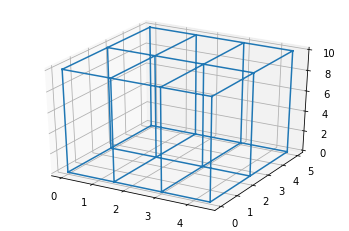

In [6]:
osbm = cbs.OctreeSubBlockModel()
osbm.parent_block_size = [1.5, 2.5, 10.]
osbm.parent_block_count = [3, 2, 1]
osbm.validate();
print('cbs: ', osbm.compressed_block_storage)
print('z_order_curves: ', osbm.z_order_curves)
print('num_blocks: ', osbm.num_blocks)
cbs_plot.plot_osbm(osbm)

cbs:  [ 0  1  2  3 18 19 20]
z_order_curves:  [        0         0         0         2   2097154   4194306   6291458
   8388610  10485762  12582914  14680066  16777217  33554433  50331649
  67108865  83886081 100663297 117440513         0         0]
num_blocks:  20


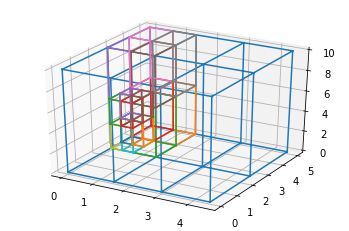

In [7]:
# This part needs work in the implementation for a high level wrapper
osbm._refine_child((0, 1, 0), 0)
osbm._refine_child((0, 1, 0), 1)

print('cbs: ', osbm.compressed_block_storage)
print('z_order_curves: ', osbm.z_order_curves)
print('num_blocks: ', osbm.num_blocks)
cbs_plot.plot_osbm(osbm)

## Octree Pointers and Level

A Z-Order curve is used to encode each octree into a linear array. The below example shows visually how the pointer and level information is encoded into a single 32 bit integer. The key pieces are to decide how many levels are possible within each tree. Choosing the current industry standard of 8 levels, allows for 256 sub-blocks in each dimension. This can accomodate 16.7 million sub-blocks within each parent block. Note that the actual block model may have many more blocks than those in a single parent block.

The `pointer` of an octree sub-block has an `ijk` index, which is the sub-block corner relative to the parent block corner, the max dimension of each is 256. There is also a `level` that corresponds to the level of the octree -- 0 corresponds to the largest block size (i.e. same as the parent block) and 7 corresponds to the smallest block size.

The sub-blocks must be refined as an octree. That is, the root block has `level=0` and `width=256`, and can be refined into 8 children - each with `level=1` and `width=128`.

In [8]:
osbm = cbs.OctreeSubBlockModel()
osbm.parent_block_size = [1.5, 2.5, 10.]
osbm.parent_block_count = [3, 2, 1]
print('Refine the (0, 0, 0) parent block.')
children = osbm._refine_child((0, 0, 0), 0)
print('The children are:')
print(children)

Refine the (0, 0, 0) parent block.
The children are:
[[0, 0, 0, 1], [128, 0, 0, 1], [0, 128, 0, 1], [128, 128, 0, 1], [0, 0, 128, 1], [128, 0, 128, 1], [0, 128, 128, 1], [128, 128, 128, 1]]


In [9]:
print('Refine the (0, 0, 0) parent block, sub-block (0, 0, 0, 1).')
children = osbm._refine_child((0, 0, 0), 1)
print('The children are:')
print(children)

Refine the (0, 0, 0) parent block, sub-block (0, 0, 0, 1).
The children are:
[[0, 0, 0, 2], [64, 0, 0, 2], [0, 64, 0, 2], [64, 64, 0, 2], [0, 0, 64, 2], [64, 0, 64, 2], [0, 64, 64, 2], [64, 64, 64, 2]]


## Linear Octree Encoding

The encoding into a linear octree is done through bit-interleaving of each location integer. This produces a [Z-Order Curve](https://en.wikipedia.org/wiki/Z-order_curve), which is a space filling curve - it garuntees a unique index for each block, and has the nice property that blocks close together are stored close together in the attribute arrays.

<center><img src="zordercurve.png" style="width:250px"><br>Visualization of the space filling Z-Order Curve</center>


In [10]:
pointer = [0, 128, 0]
level = 1
ind = z_order_utils.get_index(pointer, level)
pnt, lvl = z_order_utils.get_pointer(ind)

# assert that you get back what you put in:
assert (pointer == pnt) & (level == lvl)

print(ind)
print(pnt, lvl)

33554433
[0, 128, 0] 1


The actual encoding is completed through bit-interleaving of the three ijk-indices and then adding the level via left-shifting the integer. This is visualized in text as: 

In [11]:
z_order_utils._print_example(pointer, level);

                              001 = 1
  0  0  0  0  0  0  0  0  0  0    = 0
 0  0  1  0  0  0  0  0  0  0     = 128
0  0  0  0  0  0  0  0  0  0      = 0
000000010000000000000000000000001 = 33554433


### Octree Storage Summary

The overall storage format reduces to two arrays, (1) `csb` has length equal to the number of parent blocks; (2) `z_order_curves` has length equal to the total number of sub-blocks. This parallels standard storage formats for sparse matrices as well as standard octree storage formats. The outcome is a storage format that is compact and allows for efficient access of, for example, all sub-blocks in a parent block. The contiguous data access allows for memory-mapped arrays, among other effciencies. The format is also **twelve times more efficient** than the equivalent storage of an _Arbtrary Sub Block Model_ (one UInt32 vs six Float64 arrays). For example, a 10M cell block model **saves 3.52 GB of space** stored in this format. The format  also enforces consistentcy on the indexing of the attributes. These efficiencies, as well as classic algorithms possible for searching octree, can be taken advantage of in vendor applications both for visualization and for evaluation of other attributes.

# Arbitrary Sub Block Model

The _Arbitrary Sub Block Model_ is the most flexible and also least efficient storage format. The format allows for storage of arbitrary blocks that are contained within the parent block. The _Arbitrary Sub Block Model_ does not enforce that sub-blocks fill the entire space of the parent block.

**Stored Properties**

* `parent_block_size`: a Vector3 (Float64) that describes how large each parent block is
* `parent_block_count`: a Vector3 (Int16) that describes how many parent blocks in each dimension
* `compressed_block_storage`: a UInt32 array of length (`i * j * k + 1`) that defines delineation between octrees in the forest
* `sub_block_centroids`: a Float64 array containing the sub block centroids for all parent blocks
* `sub_block_sizes`: a Float64 array containing the sub block sizes for all parent blocks

**Centroids and Sizes**

These are stored as a two Float64 arrays as `[x_1, y_1, z_1, x_2, y_2, z_2, ...]` to ensure centroids can easily be accessed through the `cbs` indexing as well as memory mapped per parent block. The sizes and centroids are **not** normalized to the parent block, that is, they exist in the rotated coordinate frame yet are in the same units as the CRS.

_Thought_: What if we did store tham normalized? Then it easy to tell if they are out side the parent block `0 < centroid < 1`. I am thinking this way as well having to construct these by hand in the next few code blocks.

_Thought_: Should we store the `corner` instead to be consistent with the orientation of the block model storage? Storing the corner means three less operations per centroid for checking if it is contained by the parent (although one more for access, as centroid seems to be the industry standard).

Neither of the above change the storage format, just the implementation.

In [12]:
import cbs
import cbs_plot
import z_order_utils
import numpy as np
%matplotlib inline

In [13]:
asbm = cbs.ArbitrarySubBlockModel()
asbm.parent_block_size = [1.5, 2.5, 10.]
asbm.parent_block_count = [3, 2, 1]
asbm.validate();
print('cbs: ', asbm.compressed_block_storage)
print('num_blocks: ', asbm.num_blocks)
print('num_parent_blocks: ', asbm.num_parent_blocks)
# Nothing to plot to start with

cbs:  [0 0 0 0 0 0 0]
num_blocks:  0
num_parent_blocks:  6


In [14]:
def add_parent_block(asbm, ijk):
    """Nothing special about these, they are just sub-blocks."""
    pbs = np.array(asbm.parent_block_size)
    half = pbs / 2.0
    offset = half + pbs * ijk
    asbm._add_sub_blocks(ijk, offset, half*2)

cbs:  [0 3 4 5 6 7 8]
num_blocks:  8
num_parent_blocks:  6


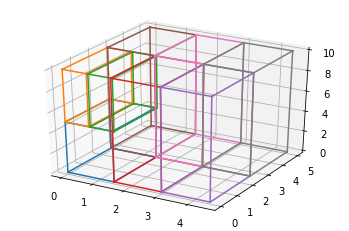

In [15]:
# Something special for the first ones
asbm._add_sub_blocks(
    (0, 0, 0), [0.75, 1.25, 2.5], [1.5, 2.5, 5.]
)
asbm._add_sub_blocks(
    (0, 0, 0), [0.375, 1.25, 7.5], [0.75, 2.5, 5.]
)
asbm._add_sub_blocks(
    (0, 0, 0), [1.175, 1.25, 7.5], [0.75, 2.5, 5.]
)
add_parent_block(asbm, (1, 0, 0))
add_parent_block(asbm, (2, 0, 0))
add_parent_block(asbm, (0, 1, 0))
add_parent_block(asbm, (1, 1, 0))
add_parent_block(asbm, (2, 1, 0))

print('cbs: ', asbm.compressed_block_storage)
print('num_blocks: ', asbm.num_blocks)
print('num_parent_blocks: ', asbm.num_parent_blocks)
cbs_plot.plot_asbm(asbm)